# Regression Deep Learning Model for Allstate Claims Severity Using TensorFlow Take 3
### David Lowe
### February 18, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The Allstate Claims Severity dataset is a regression situation where we are trying to predict the value of a continuous variable.

INTRODUCTION: Allstate is interested in developing automated methods of predicting the cost, and hence severity, of claims. In this Kaggle challenge, the contestants were asked to create an algorithm which could accurately predicts claims severity. Each row in this dataset represents an insurance claim. The task is to predict the value for the 'loss' column. Variables prefaced with 'cat' are categorical, while those prefaced with 'cont' are continuous.

In iteration Take1, we constructed machine learning models using the original dataset and with minimum data preparation and no feature engineering. The XGBoost model serves as the baseline for the future iterations of modeling.

In iteration Take2, we tuned additional parameters of the XGBoost model and improved the MAE metric further.

In this iteration, we will construct several basic Multilayer Perceptron (MLP) models with one hidden layer. This MLP model will serve as the baseline model as we build more complex MLP models in future iterations.

ANALYSIS: In iteration Take1, the baseline performance of the machine learning algorithms achieved an average MAE of 1301. eXtreme Gradient Boosting (XGBoost) achieved the top MAE metric after the first round of modeling. After a series of tuning trials, XGBoost achieved an MAE metric of 1199. By using the optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1204, which was in line with the MAE prediction from the training data.

In iteration Take2, the further-tuned eXtreme Gradient Boosting (XGBoost) model achieved an improved MAE metric of 1191 using the training data. By using the same, optimized parameters, the XGBoost algorithm processed the test dataset with an MAE of 1195, which was in line with the MAE prediction from the training data.

In this iteration Take3, the simple MLP model with 128 nodes achieved an MAE metric of 1193 on the test dataset after 50 epochs. The MLP model with 1024 nodes processed the same test dataset with an MAE of 1170 after the same number of epochs but with a much larger over-fitting.

CONCLUSION: For this iteration, the 128-node MLP model achieved good overall results using the training and testing datasets. For this dataset, we should consider experimenting with more and complex MLP models.

Dataset Used: Allstate Claims Severity Data Set

Dataset ML Model: Regression with numerical and categorical attributes

Dataset Reference: https://www.kaggle.com/c/allstate-claims-severity/data

One potential source of performance benchmarks: https://www.kaggle.com/c/allstate-claims-severity/leaderboard

Any deep-learning modeling project genrally can be broken down into about seven major tasks:

0. Prepare Environment
1. Load Data
2. Define Model
3. Fit and Evaluate Model
4. Optimize Model
5. Finalize Model

# Section 0. Prepare Environment

In [1]:
# Retrieve GPU information
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Feb 13 18:43:14 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
# Set the random seed number for reproducible results
seedNum = 888

In [0]:
# Load libraries and packages
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
import pandas as pd
import math
import os
import sys
import shutil
import urllib.request
import zipfile
import smtplib
import matplotlib.pyplot as plt
from datetime import datetime
from email.message import EmailMessage
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing

In [5]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the verbose flag to print detailed messages for debugging (setting to True will activate)
# verbose = True
# tf.debugging.set_log_device_placement(verbose)

# Set up the number of CPU cores available for multi-thread processing
n_jobs = -1
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set the number of folds for cross validation
n_folds = 5

# Set the flag for splitting the dataset
splitDataset = True
splitPercentage = 0.25

# Set various default Keras modeling parameters
default_loss = 'mae'
default_optimizer = tf.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.initializers.RandomNormal(seed=seedNum)
default_epoch = 50
default_batch = 64

Num GPUs Available:  1


In [0]:
# Set up the email notification function
def email_notify(msg_text):
    sender = os.environ.get('MAIL_SENDER')
    receiver = os.environ.get('MAIL_RECEIVER')
    gateway = os.environ.get('SMTP_GATEWAY')
    smtpuser = os.environ.get('SMTP_USERNAME')
    password = os.environ.get('SMTP_PASSWORD')
    if sender==None or receiver==None or gateway==None or smtpuser==None or password==None:
        sys.exit("Incomplete email setup info. Script Processing Aborted!!!")
    msg = EmailMessage()
    msg.set_content(msg_text)
    msg['Subject'] = 'Notification from Keras Regression Script'
    msg['From'] = sender
    msg['To'] = receiver
    server = smtplib.SMTP(gateway, 587)
    server.starttls()
    server.login(smtpuser, password)
    server.send_message(msg)
    server.quit()

In [0]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [0]:
if (notifyStatus): email_notify("Phase 0 Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 1. Load Data

In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## 1.a) Load Dataset

In [10]:
dataset_path = 'https://dainesanalytics.com/datasets/py-classification-allstate-claims-severity/train.csv'
Xy_original = pd.read_csv(dataset_path)

# Take a peek at the dataframe after the import
Xy_original.head(10)

,id,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
0,1,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,2,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,5,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,10,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,11,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,13,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,14,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,20,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,23,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,24,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [11]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 132 entries, id to loss
dtypes: float64(15), int64(1), object(116)
memory usage: 189.7+ MB


In [12]:
Xy_original.describe()

,id,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,loss
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,294135.982561,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,169336.084867,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,1.000000,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,147748.250000,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,294539.500000,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,440680.500000,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,587633.000000,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [13]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

id        0
cat1      0
cat2      0
cat3      0
cat4      0
         ..
cont11    0
cont12    0
cont13    0
cont14    0
loss      0
Length: 132, dtype: int64
Total number of NaN in the dataframe:  0


## 1.b) Data Cleaning

In [14]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'loss': 'targetVar'})

# Dropping unnecessary feature(s)
Xy_original.drop(columns=['id'], inplace=True)

# Convert columns from one data type to another
categorical_cols = ["cat" + str(i) for i in range(1,117)]
Xy_original[categorical_cols] = Xy_original[categorical_cols].astype('category')

# Take a peek at the dataframe after the cleaning
Xy_original.head(10)

,cat1,cat2,cat3,cat4,cat5,cat6,cat7,cat8,cat9,cat10,cat11,cat12,cat13,cat14,cat15,cat16,cat17,cat18,cat19,cat20,cat21,cat22,cat23,cat24,cat25,cat26,cat27,cat28,cat29,cat30,cat31,cat32,cat33,cat34,cat35,cat36,cat37,cat38,cat39,cat40,...,cat92,cat93,cat94,cat95,cat96,cat97,cat98,cat99,cat100,cat101,cat102,cat103,cat104,cat105,cat106,cat107,cat108,cat109,cat110,cat111,cat112,cat113,cat114,cat115,cat116,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
0,A,B,A,B,A,A,A,A,B,A,B,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,B,C,E,A,C,T,B,G,A,A,I,E,G,J,G,BU,BC,C,AS,S,A,O,LB,0.726300,0.245921,0.187583,0.789639,0.310061,0.718367,0.335060,0.30260,0.67135,0.83510,0.569745,0.594646,0.822493,0.714843,2213.18
1,A,B,A,A,A,A,A,A,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,L,F,A,A,E,E,I,K,K,BI,CQ,A,AV,BM,A,O,DP,0.330514,0.737068,0.592681,0.614134,0.885834,0.438917,0.436585,0.60087,0.35127,0.43919,0.338312,0.366307,0.611431,0.304496,1283.60
2,A,B,A,A,B,A,A,A,B,B,B,B,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,C,E,E,A,D,L,O,A,B,E,F,H,F,A,AB,DK,A,C,AF,A,I,GK,0.261841,0.358319,0.484196,0.236924,0.397069,0.289648,0.315545,0.27320,0.26076,0.32446,0.381398,0.373424,0.195709,0.774425,3005.09
3,B,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,C,E,E,D,T,I,D,A,A,E,E,I,K,K,BI,CS,C,N,AE,A,O,DJ,0.321594,0.555782,0.527991,0.373816,0.422268,0.440945,0.391128,0.31796,0.32128,0.44467,0.327915,0.321570,0.605077,0.602642,939.85
4,A,B,A,B,A,A,A,A,B,B,A,B,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,H,D,B,D,E,E,A,P,F,J,A,A,D,E,K,G,B,H,C,C,Y,BM,A,K,CK,0.273204,0.159990,0.527991,0.473202,0.704268,0.178193,0.247408,0.24564,0.22089,0.21230,0.204687,0.202213,0.246011,0.432606,2763.85
5,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,...,A,D,D,D,E,C,A,P,J,D,A,A,E,E,H,F,B,BI,CS,A,AS,AE,A,K,DJ,0.546670,0.681761,0.634224,0.373816,0.302678,0.364464,0.401162,0.26847,0.46226,0.50556,0.366788,0.359249,0.345247,0.726792,5142.87
6,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,...,A,D,D,D,E,C,A,P,J,A,A,C,E,E,H,F,B,BI,DK,A,J,AF,A,K,DJ,0.471447,0.737068,0.613660,0.189137,0.295397,0.381515,0.363768,0.24564,0.40455,0.47225,0.334828,0.352251,0.342239,0.382931,1132.22
7,A,B,A,B,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,A,A,A,B,A,A,A,B,A,A,A,A,A,A,A,A,...,A,C,B,C,E,A,C,T,H,C,A,A,K,F,F,I,G,BI,EB,G,AH,Y,A,P,LO,0.826591,0.488789,0.263570,0.623770,0.473767,0.867021,0.583389,0.90267,0.84847,0.80218,0.644013,0.785706,0.859764,0.242416,3585.75
8,A,B,B,B,B,A,A,A,B,B,B,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,A,A,...,A,D,C,C,E,C,D,T,C,Q,A,C,H,F,G,M,K,BI,BC,C,K,AX,A,Q,IE,0.330514,0.555782,0.440642,0.473202,0.281143,0.628534,0.384099,0.61229,0.38249,0.51111,0.682315,0.669033,0.756454,0.361191,10280.20
9,A,B,A,A,B,B,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,A,B,A,B,B,B,...,H,D,B,C,E,A,C,T,F,D,A,F,K,H,G,J,G,BU,DW,A,U,S,J,O,LY,0.726300,0.358319,0.356819,0.802892,0.310061,0.713343,0.469223,0.30260,0.67135,0.83510,0.863052,0.879347,0.822493,0.294523,6184.59


In [15]:
Xy_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 131 entries, cat1 to targetVar
dtypes: category(116), float64(15)
memory usage: 42.8 MB


In [16]:
Xy_original.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont14,targetVar
count,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000,188318.000000
mean,0.493861,0.507188,0.498918,0.491812,0.487428,0.490945,0.484970,0.486437,0.485506,0.498066,0.493511,0.493150,0.493138,0.495717,3037.337686
std,0.187640,0.207202,0.202105,0.211292,0.209027,0.205273,0.178450,0.199370,0.181660,0.185877,0.209737,0.209427,0.212777,0.222488,2904.086186
min,0.000016,0.001149,0.002634,0.176921,0.281143,0.012683,0.069503,0.236880,0.000080,0.000000,0.035321,0.036232,0.000228,0.179722,0.670000
25%,0.346090,0.358319,0.336963,0.327354,0.281143,0.336105,0.350175,0.312800,0.358970,0.364580,0.310961,0.311661,0.315758,0.294610,1204.460000
50%,0.475784,0.555782,0.527991,0.452887,0.422268,0.440945,0.438285,0.441060,0.441450,0.461190,0.457203,0.462286,0.363547,0.407403,2115.570000
75%,0.623912,0.681761,0.634224,0.652072,0.643315,0.655021,0.591045,0.623580,0.566820,0.614590,0.678924,0.675759,0.689974,0.724623,3864.045000
max,0.984975,0.862654,0.944251,0.954297,0.983674,0.997162,1.000000,0.980200,0.995400,0.994980,0.998742,0.998484,0.988494,0.844848,121012.250000


In [17]:
print(Xy_original.isnull().sum())
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

cat1         0
cat2         0
cat3         0
cat4         0
cat5         0
            ..
cont11       0
cont12       0
cont13       0
cont14       0
targetVar    0
Length: 131, dtype: int64
Total number of NaN in the dataframe:  0


## 1.c) Feature Scaling and Pre-processing

In [0]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [19]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (188318, 131) X_original.shape: (188318, 130) y_original.shape: (188318,)


## 1.d) Splitting Data into Training and Test Sets

In [20]:
# Perform one-hot-encoding before splitting into trainig and test
X_original = pd.get_dummies(X_original)
print(X_original.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 188318 entries, 0 to 188317
Columns: 1153 entries, cont1 to cat116_Y
dtypes: float64(14), uint8(1139)
memory usage: 224.7 MB
None


In [21]:
X_encoded = X_original.to_numpy()
y_encoded = y_original.to_numpy()
if (splitDataset):
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=splitPercentage, random_state=seedNum)
else:
    X_train, y_train = X_encoded, y_encoded
    X_test, y_test = X_encoded, y_encoded
print("X_train.shape: {} X_train.type: {}".format(X_train.shape, type(X_train)))
print("y_train.shape: {} y_train.type: {}".format(y_train.shape, type(y_train)))
print("X_test.shape: {} X_test.type: {}".format(X_test.shape, type(X_test)))
print("y_test.shape: {} y_test.type: {}".format(y_test.shape, type(y_test)))

X_train.shape: (141238, 1153) X_train.type: <class 'numpy.ndarray'>
y_train.shape: (141238,) y_train.type: <class 'numpy.ndarray'>
X_test.shape: (47080, 1153) X_test.type: <class 'numpy.ndarray'>
y_test.shape: (47080,) y_test.type: <class 'numpy.ndarray'>


In [0]:
if (notifyStatus): email_notify("Phase 1 Load Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 2. Define Model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #1
def create_model_1():
    default_model = Sequential()
    default_model.add(Dense(128, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [0]:
if (notifyStatus): email_notify("Phase 2 Define Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 3. Fit and Evaluate Model

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_1 = create_model_1()
baseline_hist_1 = baseline_model_1.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 7s 49us/sample - loss: 1801.1082 - val_loss: 1514.2467
Epoch 2/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1369.7491 - val_loss: 1302.2495
Epoch 3/50
141238/141238 [==============================] - 6s 45us/sample - loss: 1273.5749 - val_loss: 1271.8426
Epoch 4/50
141238/141238 [==============================] - 6s 45us/sample - loss: 1251.8317 - val_loss: 1255.1247
Epoch 5/50
141238/141238 [==============================] - 6s 46us/sample - loss: 1238.0137 - val_loss: 1244.7813
Epoch 6/50
141238/141238 [==============================] - 6s 45us/sample - loss: 1227.6068 - val_loss: 1237.1056
Epoch 7/50
141238/141238 [==============================] - 6s 44us/sample - loss: 1219.8393 - val_loss: 1231.7656
Epoch 8/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1213.3289 - val_loss: 1227.0521
Epoch 9/50
141238/141238 [===

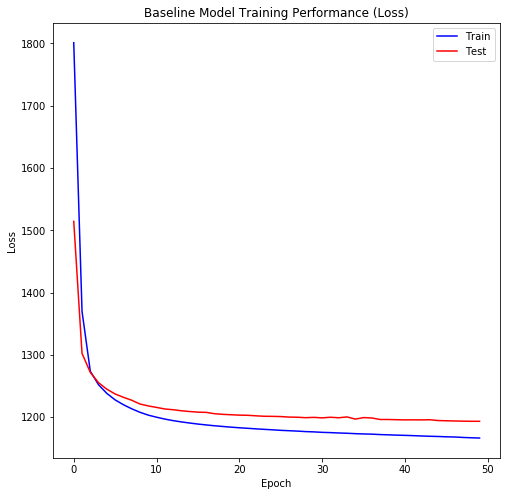

In [28]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_1.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_1.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 3 Fit and Evaluate Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 4. Optimize Model

In [0]:
if (notifyStatus): email_notify("Phase 4 Optimize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Define MLP model #2
def create_model_2():
    default_model = Sequential()
    default_model.add(Dense(256, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [32]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_2 = create_model_2()
baseline_hist_2 = baseline_model_2.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 7s 49us/sample - loss: 1474.5736 - val_loss: 1292.4446
Epoch 2/50
141238/141238 [==============================] - 6s 45us/sample - loss: 1255.7472 - val_loss: 1249.0711
Epoch 3/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1227.8555 - val_loss: 1234.2550
Epoch 4/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1214.1462 - val_loss: 1223.9531
Epoch 5/50
141238/141238 [==============================] - 7s 48us/sample - loss: 1205.5947 - val_loss: 1217.5172
Epoch 6/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1199.3913 - val_loss: 1213.4265
Epoch 7/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1195.1426 - val_loss: 1211.5586
Epoch 8/50
141238/141238 [==============================] - 7s 48us/sample - loss: 1191.7931 - val_loss: 1209.9408
Epoch 9/50
141238/141238 [===

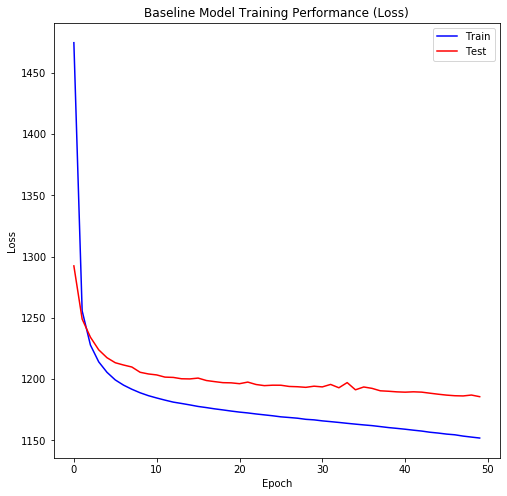

In [33]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_2.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_2.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Define MLP model #3
def create_model_3():
    default_model = Sequential()
    default_model.add(Dense(512, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [35]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_3 = create_model_3()
baseline_hist_3 = baseline_model_3.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1396.7248 - val_loss: 1263.0009
Epoch 2/50
141238/141238 [==============================] - 6s 45us/sample - loss: 1232.6874 - val_loss: 1232.4888
Epoch 3/50
141238/141238 [==============================] - 6s 46us/sample - loss: 1212.3151 - val_loss: 1222.1135
Epoch 4/50
141238/141238 [==============================] - 6s 45us/sample - loss: 1202.5232 - val_loss: 1214.3628
Epoch 5/50
141238/141238 [==============================] - 7s 46us/sample - loss: 1196.0513 - val_loss: 1209.5540
Epoch 6/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1191.0216 - val_loss: 1207.9318
Epoch 7/50
141238/141238 [==============================] - 7s 46us/sample - loss: 1187.6826 - val_loss: 1206.1363
Epoch 8/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1185.0412 - val_loss: 1206.3534
Epoch 9/50
141238/141238 [===

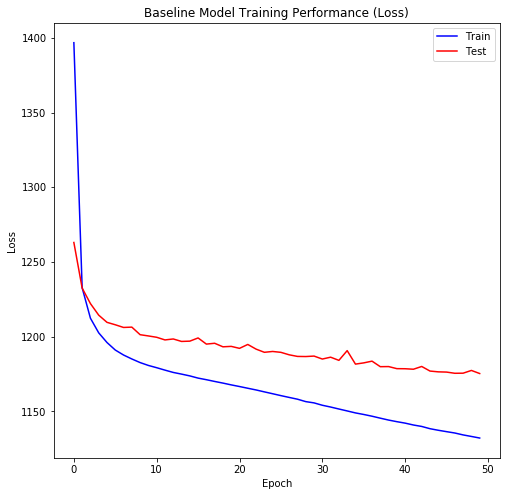

In [36]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_3.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_3.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
# Define MLP model #4
def create_model_4():
    default_model = Sequential()
    default_model.add(Dense(1024, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer=default_kernel_init))
    default_model.add(Dense(1, kernel_initializer=default_kernel_init))
    default_model.compile(loss=default_loss, optimizer=default_optimizer)
    return default_model

In [38]:
startTimeModule = datetime.now()

# Initialize the baseline model
reset_random(seedNum)
baseline_model_4 = create_model_4()
baseline_hist_4 = baseline_model_4.fit(X_train, y_train, epochs=default_epoch, batch_size=default_batch, 
                                       validation_data=(X_test, y_test), verbose=1)
print('Total time for performing cross-validation of the default model:', (datetime.now() - startTimeModule))

Train on 141238 samples, validate on 47080 samples
Epoch 1/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1336.8637 - val_loss: 1241.0062
Epoch 2/50
141238/141238 [==============================] - 7s 46us/sample - loss: 1214.8793 - val_loss: 1220.4022
Epoch 3/50
141238/141238 [==============================] - 6s 46us/sample - loss: 1200.4127 - val_loss: 1211.9568
Epoch 4/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1193.0206 - val_loss: 1206.5999
Epoch 5/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1187.8882 - val_loss: 1202.9986
Epoch 6/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1183.8584 - val_loss: 1204.3494
Epoch 7/50
141238/141238 [==============================] - 7s 47us/sample - loss: 1181.4078 - val_loss: 1203.2399
Epoch 8/50
141238/141238 [==============================] - 6s 46us/sample - loss: 1179.0123 - val_loss: 1200.3985
Epoch 9/50
141238/141238 [===

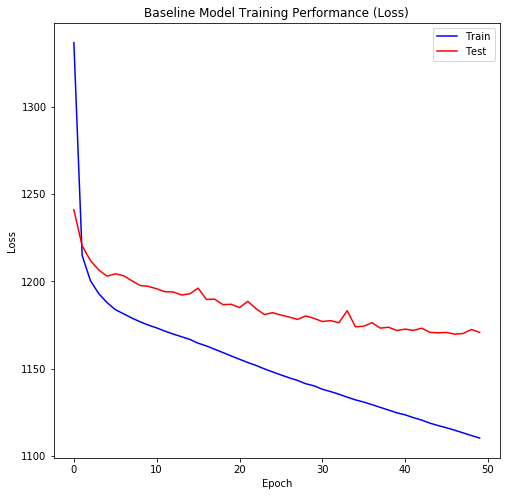

In [39]:
# Summarize model training hisotry for accuracy and loss
fig, axs = plt.subplots(1, 1, figsize=(8,8))
plt.subplot(111)
plt.plot(baseline_hist_4.history['loss'], color='blue', label='MAE - Training')
plt.plot(baseline_hist_4.history['val_loss'], color='red', label='MAE - Test')
plt.title('Baseline Model Training Performance (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [0]:
if (notifyStatus): email_notify("Phase 4 Optimize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

# Section 5. Finalize Model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [0]:
# Not applicable for this iteration of the model

In [0]:
if (notifyStatus): email_notify("Phase 5 Finalize Model completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [44]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:22:19.398410
